# Feature Engineering

In [1]:
import pandas as pd
import numpy as np
import pickle
import re
import matplotlib.pyplot as plt
from itertools import chain
from sklearn.preprocessing import StandardScaler
from joblib import Parallel, delayed

In [2]:
import os
os.chdir("../data")

## Get data

In [3]:
trial_df = pd.read_pickle("working/trial_df.pkl")
eye_ray_df = pd.read_pickle("working/eye_ray_df.pkl")
fixation_df = pd.read_pickle("working/fixation_df.pkl")
hand_pose_df = pd.read_pickle("working/hand_pose_df.pkl")
head_pose_df = pd.read_pickle("working/head_pose_df.pkl")

In [4]:
print("trial_df:", trial_df.columns)
print("eye_ray_df:", eye_ray_df.shape, eye_ray_df.columns)
print("fixation_df:", fixation_df.shape, fixation_df.columns)
print("hand_pose_df:", hand_pose_df.shape, hand_pose_df.columns)
print("head_pose_df:", head_pose_df.shape, head_pose_df.columns)

trial_df: Index(['session_id', 'start', 'end', 'condition', 'solving', 'duration'], dtype='object')
eye_ray_df: (15427, 9) Index(['timestamp', 'session_id', 'trial_id', 'origin_x', 'origin_y',
       'origin_z', 'direction_x', 'direction_y', 'direction_z'],
      dtype='object')
fixation_df: (1238, 10) Index(['timestamp', 'session_id', 'trial_id', 'x', 'y', 'z', 'duration',
       'distance', 'speed', 'angle'],
      dtype='object')
hand_pose_df: (15192, 25) Index(['timestamp', 'session_id', 'trial_id', 'left_position_x',
       'left_position_y', 'left_position_z', 'left_orientation_x',
       'left_orientation_y', 'left_orientation_z', 'left_orientation_w',
       'left_radius', 'left_accuracy', 'right_position_x', 'right_position_y',
       'right_position_z', 'right_orientation_x', 'right_orientation_y',
       'right_orientation_z', 'right_orientation_w', 'right_radius',
       'right_accuracy', 'left_orientation_angular_distance',
       'left_position_change', 'right_orientation

## Create batches for training models

In [5]:
sensor_list = ["gaze", "fixation", "hand", "head"]
sample_rate = {"gaze": 20, "fixation": 3, "hand": 20, "head": 20}

Create `sensor_data_dict` containing all the dataframes for each sensor/modality.

In [6]:
ignore_columns = ["session_id", "trial_id", "timestamp", "start", "end"]
sensor_data_dict = dict()
sensor_data_dict["gaze"] = eye_ray_df
sensor_data_dict["fixation"] = fixation_df
sensor_data_dict["hand"] = hand_pose_df
sensor_data_dict["head"] = head_pose_df
feature_columns = dict()
for sensor in sensor_list:
    feature_columns[sensor] = list(sensor_data_dict[sensor].columns.difference(ignore_columns))

Create batches using sliding windows on each of the trials.

In [60]:
def fit_scalers(leave_out_session_id):
    sensor_scaler_dict = dict()
    for sensor in sensor_list:
        X = (
            sensor_data_dict[sensor]
            .loc[
                sensor_data_dict[sensor]["session_id"] != leave_out_session_id,
                sensor_data_dict[sensor].columns.difference(ignore_columns)
            ]
            .dropna()
            .values
        )
        scaler = StandardScaler().fit(X)
        sensor_scaler_dict[sensor] = scaler
    return sensor_scaler_dict

leave_out_session_scalers = dict()
for leave_out_session_id in trial_df["session_id"].unique():
    leave_out_session_scalers[leave_out_session_id] = fit_scalers(leave_out_session_id)

pickle.dump(leave_out_session_scalers, open("working/leave_out_session_scalers.pkl", "wb"))

In [61]:
class DataLoader:
    def __init__(self, data_dict, sensor_list, sensor_rate, window_size=10, step_size=1):
        self.data_dict = data_dict
        self.sensor_list = sensor_list
        self.sensor_rate = sensor_rate
        self.window_size = window_size
        self.step_size = step_size

    def generate_trial_windows(self, session_id, trial_id):
        trial_start = trial_df.loc[
            (trial_df["session_id"] == session_id) & (trial_df.index == trial_id), "start"
        ].values[0]
        trial_end = trial_df.loc[
            (trial_df["session_id"] == session_id) & (trial_df.index == trial_id), "end"
        ].values[0]
        current_time = trial_start
        while current_time + pd.Timedelta(seconds=self.window_size) <= trial_end:
            start_time, end_time = current_time, current_time + pd.Timedelta(seconds=self.window_size)
            yield (start_time, end_time)
            current_time += pd.Timedelta(seconds=self.step_size)

    def get_window_data(self, session_id, sensor, trial_id, start_time, end_time):
        X = self.data_dict[sensor].loc[
            (self.data_dict[sensor]["session_id"] == session_id)
            & (self.data_dict[sensor]["trial_id"] == trial_id)
            & (self.data_dict[sensor]["timestamp"] >= start_time)
            & (self.data_dict[sensor]["timestamp"] < end_time),
            ["timestamp"] + feature_columns[sensor],
        ]
        expected_length = sample_rate[sensor] * self.window_size
        X = X[:expected_length]
        X = X.drop(columns=["timestamp"]).values
        X = leave_out_session_scalers[session_id][sensor].transform(X)
        if np.isnan(X).any():
            print("NAN values found")
            X = np.nan_to_num(X, nan=0.0)
        X = np.pad(X, ((0, expected_length - X.shape[0]), (0, 0)), constant_values=0)
        X = np.expand_dims(X, axis=0)
        return X

In [62]:
def generate_batches_for_session(
    session_id, trial_df, sensor_data_dict, sensor_list, sample_rate, window_size, step_size
):
    data_loader = DataLoader(sensor_data_dict, sensor_list, sample_rate, window_size, step_size)
    batch_index = pd.DataFrame(
        columns=["session_id", "trial_id", "start_time", "end_time", "label"]
    )
    batch_data = []

    for trial_id in trial_df[trial_df["session_id"] == session_id].index:
        for start_time, end_time in data_loader.generate_trial_windows(session_id, trial_id):
            # create new batch
            batch_id = len(batch_data)
            label = trial_df.loc[
                (trial_df["session_id"] == session_id) & (trial_df.index == trial_id),
                "solving",
            ].values[0]
            batch_index.loc[batch_id] = (session_id, trial_id, start_time, end_time, label)
            
            # add sensor data to batch
            batch_data.append(dict())
            for sensor in sensor_list:
                batch_data[batch_id][sensor] = data_loader.get_window_data(
                    session_id, sensor, trial_id, start_time, end_time
                )

    return {
        "index": batch_index,
        "data": batch_data
    }

In [63]:
window_size = 10
step_size = 1
try_loading_first = True

if (
    try_loading_first
    and os.path.exists("working/batch_index.pkl")
    and os.path.exists("working/batch_data.pkl")
):
    print("Loading batches from file")
    batch_index = pd.read_pickle("working/batch_index.pkl")
    batch_data = pickle.load(open("working/batch_data.pkl", "rb"))
else:
    print("Generating batches from scratch using LoSo")

    unique_session_id = list(trial_df["session_id"].unique())
    batches = Parallel(n_jobs=-1)(
        delayed(generate_batches_for_session)(
            session_id, trial_df, sensor_data_dict, sensor_list, sample_rate, window_size, step_size
        )
        for session_id in unique_session_id
    )
    batch_index = (
        pd.concat([batch["index"] for batch in batches], ignore_index=True)
        .reset_index()
        .rename(columns={"index": "batch_id"})
    )
    batch_data = list(chain.from_iterable(batch["data"] for batch in batches))
    
    batch_index.to_pickle("working/batch_index.pkl")
    pickle.dump(batch_data, open("working/batch_data.pkl", "wb"))

Loading batches from file


To do:
- add this to generate_batches_for_session(), and then use it to generate the features for each window (after line 25)
- however this will only make sense for deep learning. so maybe do that later.

In [64]:
def calculate_features_for_sensor(sensor, window_df):
    feature_series = pd.Series()
    for column in window_df.columns:
        if not re.match(".*(w|x|y|z)", column):
            feature_series[f"{sensor}_{column}_mean"] = window_df[column].mean()
            feature_series[f"{sensor}_{column}_median"] = window_df[column].median()
            feature_series[f"{sensor}_{column}_std"] = window_df[column].std()
            feature_series[f"{sensor}_{column}_min"] = window_df[column].min()
            feature_series[f"{sensor}_{column}_max"] = window_df[column].max()
            feature_series[f"{sensor}_{column}_sum_abs_diff"] = window_df[column].diff().abs().sum()
    return feature_series

def get_batch_features(batch_id):
    feature_df_list = [
        calculate_features_for_sensor(sensor, pd.DataFrame(batch_data[batch_id][sensor][0], columns=feature_columns[sensor]))
        # for sensor in ["fixation"]
        for sensor in sensor_list
    ]
    batch_features = pd.concat([
        feature_df 
        for feature_df in feature_df_list
        if not feature_df.empty
    ])
    return batch_features

In [65]:
feature_df = pd.concat([
    get_batch_features(batch_id)
    for batch_id in batch_index.index
], axis=1).T
feature_df.head()

,fixation_angle_mean,fixation_angle_median,fixation_angle_std,fixation_angle_min,fixation_angle_max,fixation_angle_sum_abs_diff,fixation_distance_mean,fixation_distance_median,fixation_distance_std,fixation_distance_min,...,head_position_change_std,head_position_change_min,head_position_change_max,head_position_change_sum_abs_diff,head_up_angular_distance_mean,head_up_angular_distance_median,head_up_angular_distance_std,head_up_angular_distance_min,head_up_angular_distance_max,head_up_angular_distance_sum_abs_diff
0,0.121525,0.000000,0.916301,-0.425595,4.046378,7.809494,0.137840,0.000000,0.996743,-0.440477,...,0.962893,-0.880621,3.533055,50.710961,0.933903,0.643825,1.336067,-0.911502,6.320924,117.358072
1,-0.148149,0.000000,0.175483,-0.425595,0.000000,2.136649,-0.154345,0.000000,0.176942,-0.440477,...,0.745691,-0.880621,3.517845,46.986048,0.858879,0.622864,1.261139,-0.911502,6.232038,100.708243
2,-0.154662,0.000000,0.186983,-0.558451,0.000000,2.324522,-0.163506,0.000000,0.193061,-0.611003,...,0.676579,-0.880621,3.517845,42.846856,0.831347,0.600636,1.250563,-0.911502,6.232038,100.811382
3,-0.173292,-0.073749,0.191273,-0.558451,0.000000,2.813759,-0.189585,-0.165971,0.200079,-0.611003,...,0.542075,-0.880621,1.719384,37.131575,0.743185,0.566120,1.135428,-0.911502,5.465570,95.373637
4,-0.180949,-0.073749,0.201432,-0.558451,0.000000,3.167004,-0.198138,-0.165971,0.209672,-0.611003,...,0.533423,-0.930491,1.719384,36.950884,0.773495,0.576888,1.148181,-0.911502,5.465570,94.978608


In [66]:
feature_df.to_pickle("working/feature_df.pkl")

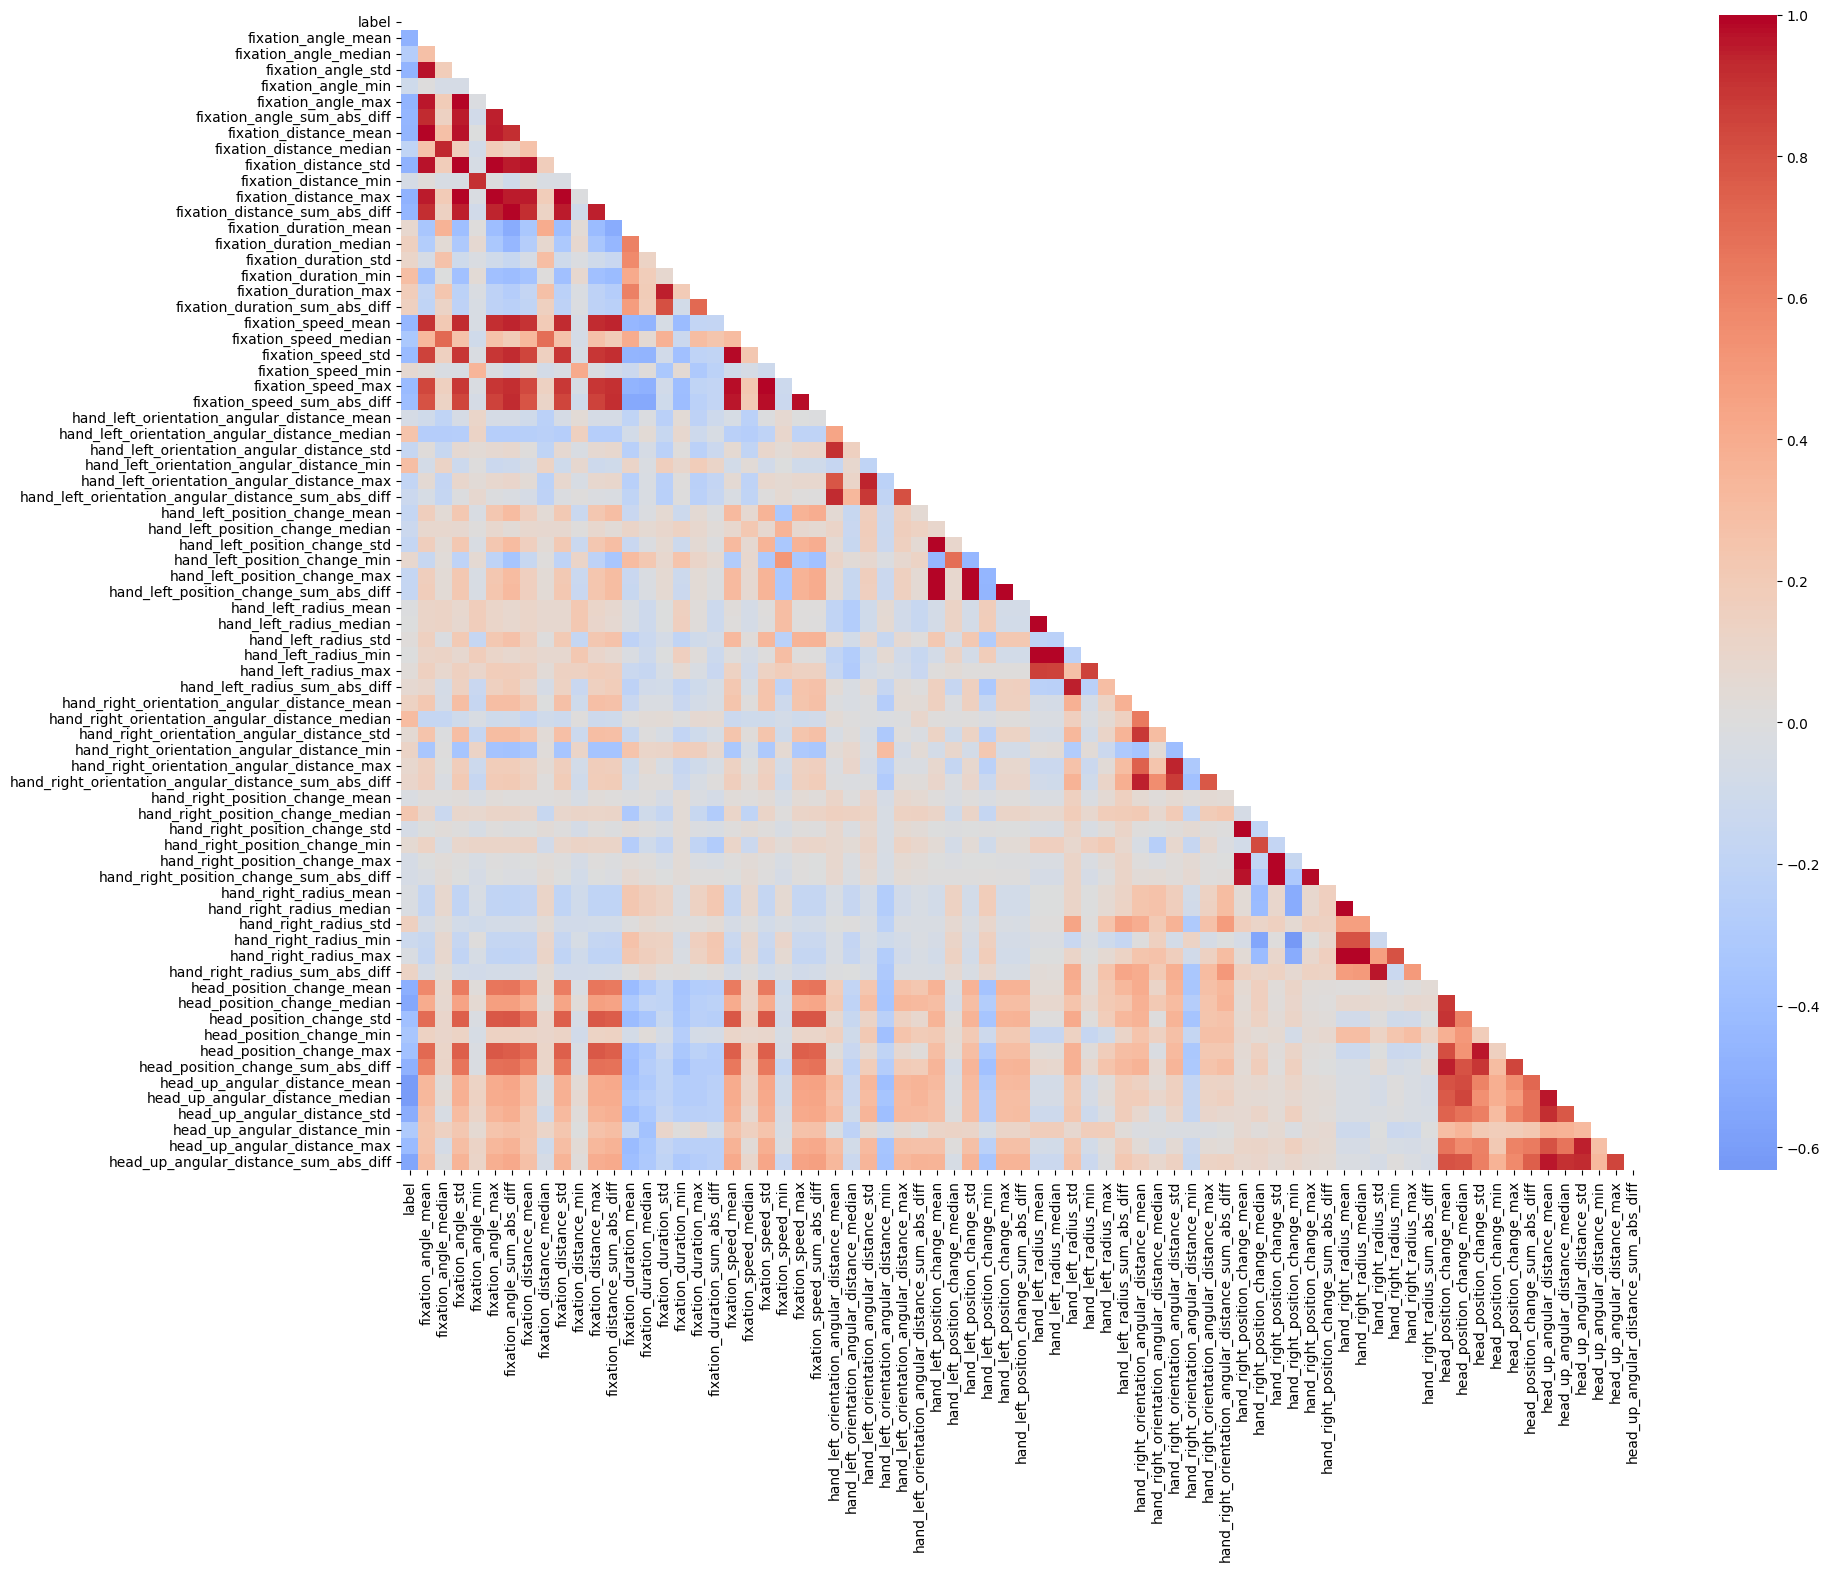

In [72]:
import seaborn as sns

correlation = pd.DataFrame(batch_index["label"]).merge(feature_df, left_index=True, right_index=True).corr()
mask = np.triu(np.ones_like(correlation, dtype=bool))
plt.figure(figsize=(20, 15))
sns.heatmap(correlation, mask=mask, cmap="coolwarm", center=0, annot=False, fmt=".2f")
plt.show()